<a href="https://colab.research.google.com/github/marneneha/3d-object-segmentation/blob/master/homeworks/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [5]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul
!pip install scikit-learn

Cloning into 'deepul'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 270 (delta 51), reused 32 (delta 32), pack-reused 188 (from 2)
Receiving objects: 100% (270/270), 94.71 MiB | 38.84 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22739 sha256=3d88706677a952e28693cd49aceae71e3763d92f7a48d14d95aa1eeaba58203a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ro6dwvzo/wheels/ef/ca/e6/838f85393ab50f0d590acc4f5cfa805863e523ebaee1b400c4
Successfully built deepul


In [6]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

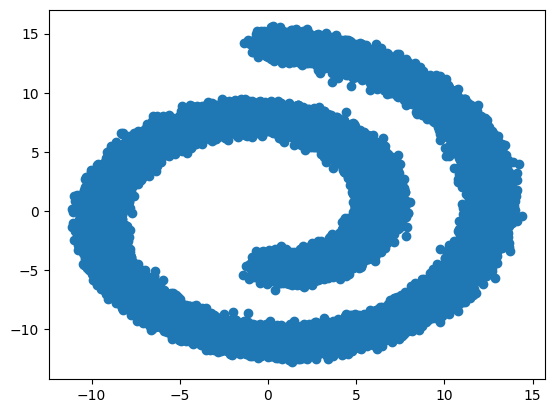

In [7]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [8]:
from torchvision import transforms
import torch
def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """

    """ YOUR CODE HERE """
    train_data = torch.from_numpy(train_data).float()
    test_data = torch.from_numpy(test_data).float()
    train_mean = torch.mean(train_data, dim=0)
    train_std = torch.std(train_data, dim=0)
    train_data = (train_data - train_mean) / train_std
    print("train_mean is", train_mean)
    print("test std is", train_std)
    return train_losses, test_losses, all_samples

In [11]:
# def q1_save_results(q1):
#   train_data, test_data = get_q1_data()
#   q1(train_data, test_data)
q1_save_results(q1)

NameError: name 'get_q1_data' is not defined

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

In [ ]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """

    """ YOUR CODE HERE """

    return train_losses, test_losses, samples

In [ ]:
q2_save_results(q2)

# Question 3: Class-Conditional Latent-Space Diffusion on CIFAR-10 with DiT [60pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10 **with class conditioning.**

Execute the cell below to visualize our datasets.

In [ ]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.

In [ ]:
# @property
# def latent_shape(self) -> Tuple[int, int, int]:
#     """Size of the encoded representation"""
#
# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1
#
#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#
#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """
#
# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.
#
#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """
#

In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

In [ ]:
def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """

    """ YOUR CODE HERE """

    return autoencoded_images, scale_factor

In [ ]:
q3a_save_results(q3_a)

## Part 3(b) Diffusion Transformer [30pt]
In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.
```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

**Hyperparameter details**
* Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder
* For diffusion schedule, sampling and loss, use the same setup as Q1

For class conditioning, learn an embedding for each class, and an extra embedding to represent the null class. To condition, add the class embedding to the timestep embedding before feeding it into the transformer blocks (see pseudocode). **Train your class conditional diffusion models while dropping out the class (replace with null class) 10% of the time. This will be necessary for part (c).**

**Remember to save your model parameters after training, as you will need them for part (c)**

In [ ]:
def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """

    """ YOUR CODE HERE """

    return train_losses, test_losses, samples

In [ ]:
q3b_save_results(q3_b)

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

In [ ]:
def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """

    """ YOUR CODE HERE """

    return samples

In [ ]:
q3c_save_results(q3_c)